In [0]:
import pickle
import pylab
import numpy as np
import csv
import pandas as pd
import time as time
import scipy.ndimage as img
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'1KrCyB8w_Su3H7RA1NokEtqZ_LjZ2EHob'})
downloaded.GetContentFile('train_max_x')    

train_images = pd.read_pickle('train_max_x') 

# downloaded = drive.CreateFile({'id':'1n02LQULkmKrrzHdILoYBIa_182LlHAWs'}) 
# downloaded.GetContentFile('test_max_x')    

# test_images = pd.read_pickle('test_max_x')

In [0]:
import cv2
import scipy.ndimage as img
# from datetime import datetime
import scipy.misc as dfg
import matplotlib.pyplot as plt

In [4]:
import cv2
import keras
def getResult(inputImage, model):
  inputImage = inputImage.astype(np.uint8)
  _,thres0 = cv2.threshold(inputImage, 252, 255, 0)
  kernel_connect = np.array([[1,1,1], [1,0,1], [1,1,1]], np.uint8)
  thres0 = cv2.dilate(thres0, kernel_connect, iterations = 2)
  _, contours, hierarchy = cv2.findContours(thres0, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  while len(contours)>3 :
    minIndex = 0
    minArea = 1000
    for i in range(len(contours)) :
      if cv2.contourArea(contours[i]) < minArea :
        minIndex = i
        minArea = cv2.contourArea(contours[i])
    del contours[minIndex]
  
  digits3 = 0
  for i in range(len(contours)) :
    [x, y, w, h] = cv2.boundingRect(contours[i])
    digit = inputImage[y:y + h, x:x + w]
    _,digit0 = cv2.threshold(digit, 240, 255, 0)
    digit0 = cv2.dilate(digit0, kernel_connect, iterations = 1)
    _, contours0, hierarchy0 = cv2.findContours(digit0, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    fcontour = contours0[0]
    if len(contours)>1:
      maxIndex = 0
      maxArea = 0
      for j in range(len(contours0)) :
        if cv2.contourArea(contours[i]) > maxArea :
          maxIndex = j
          maxArea = cv2.contourArea(contours[j])
      fcontour = contours0[maxIndex]
    stencil = np.zeros(digit.shape).astype(digit.dtype)
    cv2.fillPoly(stencil, [fcontour], 255)
    digit1 = cv2.bitwise_and(digit, stencil)
    if digit1.shape[0] > 28:
      height = int(28*digit1.shape[1]/digit1.shape[0])
      digit1 = cv2.resize(digit1, (28, height))
    if digit1.shape[1] > 28:
      width = int(28*digit1.shape[0]/digit1.shape[1])
      digit1 = cv2.resize(digit1, (width, 28))
    if digit1.shape[0] > 28:
      height = int(28*digit1.shape[1]/digit1.shape[0])
      digit1 = cv2.resize(digit1, (28, height))
    if (digit1.shape[0] < 28) or (digit1.shape[1] < 28):
      dx = max(28 - digit1.shape[1], 0)
      dy = max(28 - digit1.shape[0], 0)
      top = int(dy/2)+int(dy%2)
      bottom = int(dy/2)
      left = int(dx/2)+int(dx%2)
      right = int(dx/2)
      digit1 = cv2.copyMakeBorder(digit1, top, bottom, left, right, cv2.BORDER_CONSTANT, 0)
    #print(digit1.shape)
    digit1 = digit1.reshape(1,28,28,1)
    if i == 0:
      digits3 = digit1
    else:
      digits3 = np.append(digits3, digit1, axis=0)
  pResult = model.predict(digits3)
  return max(np.where(pResult==1)[1])

Using TensorFlow backend.


In [0]:
import keras
import time
downloaded = drive.CreateFile({'id':'1yxkV-G4n4vEXy8nLQmb4-KofhiHkOS6I'})
downloaded.GetContentFile('modelmcnn.h5') 
model = keras.models.load_model('modelmcnn.h5')

In [0]:
# pylab.imshow(train_images[22046])
# print(getResult(train_images[22046], model))
pred = []
for i in range(test_images.shape[0]) :
  pred = np.append(pred, getResult(test_images[i], model))
print('predicting complete!')
pred = pd.DataFrame(pred, columns=['Label'])
pred.to_csv('predResult.csv', index=True, index_label='Id', header=True)
fileName = 'cut'+time.strftime("%Y%m%d%H", time.localtime())+'.csv'
uploaded = drive.CreateFile({'title': fileName})
uploaded.SetContentFile('predResult.csv')
uploaded.Upload()

predicting complete!


(128, 128)
(22, 22)


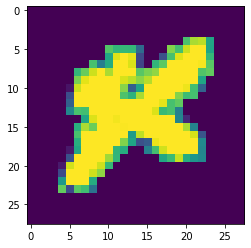

In [0]:
tmp_train_images = train_images[4256].astype(np.uint8)
print(tmp_train_images.shape)
_,thres0 = cv2.threshold(tmp_train_images, 252, 255, 0)
#_,thres0 = cv2.adaptiveThreshold(tmp_train_images,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
#thres0 = cv2.adaptiveThreshold(tmp_train_images,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,-5)
kernel_connect = np.array([[1,1,1], [1,0,1], [1,1,1]], np.uint8)
thres0 = cv2.dilate(thres0, kernel_connect, iterations = 2)
_, contours, hierarchy = cv2.findContours(thres0, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
while len(contours)>3 :
  minIndex = 0
  minArea = 1000
  for i in range(len(contours)) :
    if cv2.contourArea(contours[i]) < minArea :
      minIndex = i
      minArea = cv2.contourArea(contours[i])
  del contours[minIndex]
#cv2.drawContours(thres0,contours,-1,125,1)
#pylab.imshow(thres0)
[x, y, w, h] = cv2.boundingRect(contours[2])
digit = tmp_train_images[y:y + h, x:x + w]
_,digit0 = cv2.threshold(digit, 240, 255, 0)
digit0 = cv2.dilate(digit0, kernel_connect, iterations = 1)
#digit = cv2.adaptiveThreshold(digit,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,0)
_, contours0, hierarchy0 = cv2.findContours(digit0, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
fcontour = contours0[0]
if len(contours)>1:
  maxIndex = 0
  maxArea = 0
  for i in range(len(contours0)) :
    if cv2.contourArea(contours[i]) > maxArea :
      maxIndex = i
      maxArea = cv2.contourArea(contours[i])
  fcontour = contours0[maxIndex]
stencil = np.zeros(digit.shape).astype(digit.dtype)
cv2.fillPoly(stencil, [fcontour], 255)
digit1 = cv2.bitwise_and(digit, stencil)
#digit1 = cv2.erode(digit1, kernel_connect, iterations = 1)
print(digit1.shape)
if digit1.shape[0] > 28:
  height = int(28*digit1.shape[1]/digit1.shape[0])
  digit1 = cv2.resize(digit1, (28, height))
if digit1.shape[1] > 28:
  width = int(28*digit1.shape[0]/digit1.shape[1])
  digit1 = cv2.resize(digit1, (width, 28))
if (digit1.shape[0] < 28) or (digit1.shape[1] < 28):
  dx = 28 - digit1.shape[1]
  dy = 28 - digit1.shape[0]
  top = int(dy/2)+int(dy%2)
  bottom = int(dy/2)
  left = int(dx/2)+int(dx%2)
  right = int(dx/2)
  digit1 = cv2.copyMakeBorder(digit1, top, bottom, left, right, cv2.BORDER_CONSTANT, 0)
pylab.imshow(digit1)

In [0]:
# import keras
# downloaded = drive.CreateFile({'id':'1yxkV-G4n4vEXy8nLQmb4-KofhiHkOS6I'})
# downloaded.GetContentFile('modelmcnn.h5') 
# model = keras.models.load_model('modelmcnn.h5')
digitR = digit1.reshape(1,28,28,1)
pResult = model.predict(digitR)
print(pResult)
np.where(pResult==1)[1]

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 9.9999940e-01
  0.0000000e+00 0.0000000e+00 0.0000000e+00 6.0097796e-07 0.0000000e+00]]


array([], dtype=int64)

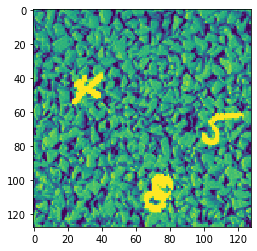

In [0]:
pylab.imshow(train_images[4256])
#print(getResult(test_images[5164], model))

In [0]:
print(np.append([[[[1],[2]],[[3],[4]]]],[[[[5],[6]],[[7],[8]]]],axis=0))

[[[[1]
   [2]]

  [[3]
   [4]]]


 [[[5]
   [6]]

  [[7]
   [8]]]]


In [0]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 11

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
  x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
  x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
  input_shape = (1, img_rows, img_cols)
else:
  x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
  x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
  input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))
model.save('modelmcnn.h5')    
model_file = drive.CreateFile({'title' : 'modelmcnn.h5'})
model_file.SetContentFile('modelmcnn.h5')
model_file.Upload()
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/11
60000/60000 [==============================] - 9s 156us/step - loss: 0.2668 - acc: 0.9184 - val_loss: 0.0583 - val_acc: 0.9810
Epoch 2/11
60000/60000 [==============================] - 9s 146us/step - loss: 0.0903 - acc: 0.9733 - val_loss: 0.0524 - val_acc: 0.9823
Epoch 3/11
60000/60000 [==============================] - 9s 146us/step - loss: 0.0669 - acc: 0.9810 - val_loss: 0.0326 - val_acc: 0.9893
Epoch 4/11
60000/60000 [==============================] - 9s 148us/step - loss: 0.0558 - acc: 0.9837 - val_loss: 0.0346 - val_acc: 0.9892
Epoch 5/11
60000/60000 [==============================] - 9s 148us/step - loss: 0.0489 - acc: 0.9856 - val_loss: 0.0294 - val_acc: 0.9906
Epoch 6/11
60000/60000 [==============================] - 9s 146us/step - loss: 0.0405 - acc: 0.9880 - val_loss: 0.0311 - val_acc: 0.9899
Epoch 7/11
60000/60000 [=========================